<a href="https://colab.research.google.com/github/jrojasquiroz/hppAI/blob/main/evacal/4-correlaciones_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importo las librerías necesarias e indico las rutas en donde están alojadas las imágenes a entrenar y los modelos por cada dimensión (`B_contempo`, `B_estado`, etc.).

In [68]:
pip install factor_analyzer

In [69]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models
from factor_analyzer import FactorAnalyzer #librería especializada para hacer ACP
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm #para hacer modelos OLS

from google.colab import drive
drive.mount('/content/drive')

# Definir rutas
ruta_base = "/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/evacal/orden_cuarto_intento"
ruta_inicial = "/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/evacal/cuarto_intento/imagenes_nuevo"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Indico que los modelos sean ejecutados y que aquellos casos que no tengan suficientes fotos (porque, por error, los hay) indiquen el valor 999 en las columnas correspondientes.

*(El código funciona correctamente, por error lo volví a correr pero sabiendo que tarda aproximadamente 3 horas en terminar de ejecutarse lo detuve).*

In [70]:
# Definir modelos y sus rutas
modelos = {
    'B': ['B_contempo', 'B_estado', 'B_lavamano'],
    'C': ['C_contempo', 'C_estado', 'C_armarios'],
    'R': ['R_contempo', 'R_estado', 'R_singular', 'R_ventana', 'R_carpinteria']
}

# Función para cargar modelos
def cargar_modelos():
    modelos_cargados = {}
    for categoria, submodelos in modelos.items():
        for submodelo in submodelos:
            modelo_path = os.path.join(ruta_base, submodelo, 'mimodelo.keras')
            modelos_cargados[submodelo] = models.load_model(modelo_path)
    return modelos_cargados

# Cargar todos los modelos
modelos_cargados = cargar_modelos()

# Definir tamaño de las imágenes
width, height = 580, 580

# Función para predecir con los modelos y obtener el valor correspondiente
def predecir_valor(modelo, img_path):
    try:
        img = cv2.imread(img_path)
        resized_image = cv2.resize(img, (width, height))
        img_array = np.array([resized_image])
        prediccion = modelo.predict(img_array)
        return np.argmax(prediccion)
    except Exception as e:
        print(f"Error al predecir {img_path}: {e}")
        return 999

# Función para procesar cada carpeta de caso
def procesar_carpeta_caso(caso_id, modelos_cargados):
    resultados = {'ID': caso_id}
    caso_path = os.path.join(ruta_inicial, caso_id)

    for letra, submodelos in modelos.items():
        letra_path = os.path.join(caso_path, letra)
        if not os.path.exists(letra_path):
            for submodelo in submodelos:
                resultados[submodelo] = 999
            continue

        for submodelo in submodelos:
            modelo = modelos_cargados[submodelo]
            submodelo_resultados = []
            for img_file in os.listdir(letra_path):
                if img_file.endswith(('.png', '.jpg')):
                    img_path = os.path.join(letra_path, img_file)
                    valor = predecir_valor(modelo, img_path)
                    submodelo_resultados.append(valor)

            if submodelo_resultados:
                resultados[submodelo] = max(set(submodelo_resultados), key=submodelo_resultados.count)
            else:
                resultados[submodelo] = 999

    return resultados

# Crear DataFrame para resultados
resultados_df = pd.DataFrame(columns=['ID'] + [submodelo for submodelos in modelos.values() for submodelo in submodelos])

# Procesar todas las carpetas de casos
resultados_lista = []
for caso_id in os.listdir(ruta_inicial):
    if os.path.isdir(os.path.join(ruta_inicial, caso_id)):
        resultados_caso = procesar_carpeta_caso(caso_id, modelos_cargados)
        resultados_lista.append(resultados_caso)

resultados_df = pd.concat([resultados_df, pd.DataFrame(resultados_lista)], ignore_index=True)

# Guardar resultados en un archivo Excel
resultados_df.to_excel(os.path.join(ruta_inicial, 'resultados.xlsx'), index=False)

1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 26ms/step


KeyboardInterrupt: 

Ahora sólo queda pendiente (1) volver todos los IDs a números, (2) eliminar aquellas filas que tengan al menos un valor 999, (3) hacer un Análisis de Componentes Principales para obtener una variable similar a `Estado_contemporaneidad_calidad`, (4) correlacionar el resultado del ACP con el precio real de las viviendas y (5) realizar los pasos 3 y 4 con el dataset original, cuidando que los IDs sean los mismos.

In [71]:
df=pd.read_excel(os.path.join(ruta_inicial,'resultados.xlsx'))
df.head(2)

,ID,B_contempo,B_estado,B_lavamano,C_contempo,C_estado,C_armarios,R_contempo,R_estado,R_singular,R_ventana,R_carpinteria
0,8,1,2,1,1,2,1,1,1,0,0,1
1,9,1,2,1,1,2,1,3,1,0,0,1


In [72]:
df['ID']=pd.to_numeric(df['ID'])
len(df)

1410

## (2) Eliminar aquellas filas que tengan al menos un valor 999

In [73]:
# Primero seleccionamos todas las columnas excepto 'ID'
columns_to_check = df.columns.difference(['ID'])

# Luego usamos la indexación booleana para filtrar las filas
df = df[~df[columns_to_check].eq(999).any(axis=1)]

len(df)

1338

## (3) Hacer un Análisis de Componentes Principales para obtener una variable similar a `Estado_contemporaneidad_calidad`

In [74]:
calidad=['C_contempo', 'C_estado', 'C_armarios', 'B_contempo', 'B_estado',
       'B_lavamano', 'R_contempo', 'R_estado', 'R_carpinteria', 'R_singular',
       'R_ventana']

#Le indicamos en qué columnas se va a centrar
acp = df[calidad]

#Le pedimos un ACP con rotación varimax y N factores
fa = FactorAnalyzer(rotation='varimax', n_factors=7, #esto lo indican ustedes, deben ir probando
                    method='principal')
fa.fit(acp)

# Obtener la varianza total explicada
total_variance = fa.get_factor_variance()

# Crear un DataFrame para mostrar la tabla de la varianza total explicada
explained_variance_df = pd.DataFrame(total_variance, columns=['Factor1', 'Factor2','Factor3','Factor4',
                                                              'Factor5','Factor6','Factor7'], #Deben aumentar o disminuir según la
                                                                         #cantidad de factores que hayan indicado
                                     index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

#Esto es solo para que la tabla se vea mejor
explained_variance_df = explained_variance_df.transpose()

print("Tabla de Varianza Total Explicada:")
print(explained_variance_df)

Tabla de Varianza Total Explicada:
         SS Loadings  Proportion Var  Cumulative Var
Factor1     1.223501        0.111227        0.111227
Factor2     1.293440        0.117585        0.228813
Factor3     1.216754        0.110614        0.339427
Factor4     1.038820        0.094438        0.433865
Factor5     1.121298        0.101936        0.535801
Factor6     1.042183        0.094744        0.630545
Factor7     1.044524        0.094957        0.725502


In [75]:
rotated_loadings = fa.loadings_

# Transponer la matriz de cargas rotadas para que las columnas coincidan con las variables
rotated_loadings_transposed = rotated_loadings.T

rotated_df = pd.DataFrame(rotated_loadings_transposed, columns=acp.columns)

rotated_df

,C_contempo,C_estado,C_armarios,B_contempo,B_estado,B_lavamano,R_contempo,R_estado,R_carpinteria,R_singular,R_ventana
0,0.821508,0.603344,0.049474,0.170887,-0.043518,0.070051,0.035020,0.330179,-0.148351,0.117789,0.004876
1,-0.066853,0.279828,-0.013960,0.057569,0.252381,0.013781,-0.010852,0.683531,0.802868,0.018496,0.176067
2,0.189510,-0.015651,0.012882,0.811084,0.367835,0.032917,0.612489,0.050334,0.024209,-0.034532,0.082045
3,-0.075926,0.274144,0.952039,0.008741,0.172166,0.000829,-0.011193,0.031914,-0.029715,-0.025686,0.138260
4,0.027248,0.193763,-0.031346,-0.187208,0.290294,0.004099,0.408027,-0.000196,0.024471,0.888421,0.079480
5,0.031583,0.067350,0.002538,0.014340,0.270416,0.972375,0.032052,0.066941,-0.031106,0.001398,0.106399
6,0.126766,-0.174599,0.092947,-0.103864,-0.497144,0.050265,0.299969,-0.050044,0.160294,-0.002396,0.781459


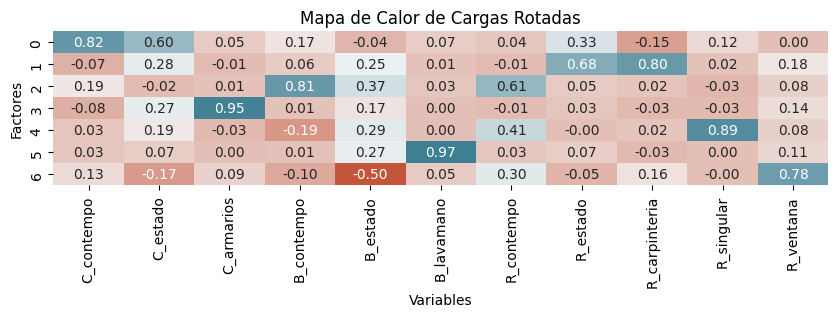

In [76]:
# Definir los colores para el mapa de calor
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Crear el mapa de calor
plt.figure(figsize=(10, 2)) #Altura y ancho, lo pueden variar
sns.heatmap(rotated_df, cmap=cmap, annot=True, fmt=".2f", cbar=False, vmin=rotated_df.min().min(), vmax=rotated_df.max().max())
plt.title('Mapa de Calor de Cargas Rotadas')
plt.xlabel('Variables')
plt.ylabel('Factores')
plt.show()

In [77]:
df_og=pd.read_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/evacal/cuarto_intento/data/v-muestra_rmb-abril24-responsables.xlsx')
print(df_og.columns.tolist())

['ID', 'Title', 'Link', 'precio_euros', 'codigo_inmueble', 'Description', 'last_mod', 'dummy_indice', 'indice_alquiler', 'area', 'n_rooms', 'price_m2', 'n_baths', 'n_aseo', 'laundry', 'buhardilla', 'despacho', 'trastero', 'terrace', 'kwhm2_year', 'kgCO2m2_year', 'dummy_consum_EPC', 'dummy_emission_EPC', 'consum_A', 'consum_B', 'consum_C', 'consum_D', 'consum_E', 'consum_F', 'consum_G', 'emission_A', 'emission_B', 'emission_C', 'emission_D', 'emission_E', 'emission_F', 'emission_G', 'AC', 'parking', 'pool', 'lift', 'furniture', 'public_transp', 'barrio', 'codigo_inmueble_numero', 'Lat_Y', 'Lon_X', 'multifam', 'atico', 'duplex', 'estudio', 'loft', 'piso', 'triplex', 'invalido', 'prob_sin_foto', 'qprecio', 'MUN', 'qprecio_municipio', 'C_contempo', 'C_estado', 'C_armarios', 'B_contempo', 'B_estado', 'B_lavamano', 'R_contempo', 'R_estado', 'R_carpinteria', 'R_singular', 'R_ventana', 'dumi_precio_reduccion', 'Precio_reduccion', 'Anuncio_invalido', 'Responsable']


In [78]:
df = pd.merge(df, df_og[['ID', 'precio_euros']], on='ID', how='left')
len(df) #para estar seguros de que no pasó nada raro

1338

## (5) Realizar los pasos 3 y 4 con el dataset original, cuidando que los IDs sean los mismos

In [79]:
len(df_og)

3456

In [80]:
# Filtrar df_og para mantener solo las filas cuyos IDs están en df
df_og = pd.merge(df_og, df[['ID']], on='ID', how='inner')
len(df_og)

1338

### Análisis de Componentes Principales

In [81]:
df_og[calidad].head(2)

,C_contempo,C_estado,C_armarios,B_contempo,B_estado,B_lavamano,R_contempo,R_estado,R_carpinteria,R_singular,R_ventana
0,1,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0
1,1,2.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,0.0


Parece que `C_contempo` no está en formato numérico. Voy a convertirlo y hacer un *coerce* por si las dudas.

In [82]:
df_og.to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/evacal/df_og.xlsx')

In [87]:
# Convertimos la columna 'C_contempo' a numérica, convirtiendo valores no válidos a NaN
columns_to_convert = ['B_contempo', 'B_estado', 'B_lavamano', 'C_contempo', 'C_estado', 'C_armarios', 'R_contempo', 'R_estado', 'R_singular', 'R_ventana', 'R_carpinteria']
df_og[columns_to_convert] = df_og[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_og[calidad].isna().sum()

C_contempo       51
C_estado         51
C_armarios       52
B_contempo       53
B_estado         52
B_lavamano       52
R_contempo       53
R_estado         52
R_carpinteria    52
R_singular       61
R_ventana        54
dtype: int64

Confirmo que hay valores *NaN* en algunas filas (lo exporté y revisé manualmente). Voy a eliminarlas.

In [90]:
df_og = df_og.dropna(subset=calidad)

In [91]:
len(df_og)

1272

In [92]:
#Le indicamos en qué columnas se va a centrar
acp2 = df_og[calidad]

#Le pedimos un acp2 con rotación varimax y N factores
fa2 = FactorAnalyzer(rotation='varimax', n_factors=5, #esto lo indican ustedes, deben ir probando
                    method='principal')
fa2.fit(acp2)

# Obtener la varianza total explicada
total_variance = fa2.get_factor_variance()

# Crear un DataFrame para mostrar la tabla de la varianza total explicada
explained_variance_df_og = pd.DataFrame(total_variance, columns=['Factor1', 'Factor2','Factor3','Factor4',
                                                              'Factor5'], #Deben aumentar o disminuir según la
                                                                         #cantidad de factores que hayan indicado
                                     index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

#Esto es solo para que la tabla se vea mejor
explained_variance_df_og = explained_variance_df_og.transpose()

print("Tabla de Varianza Total Explicada:")
print(explained_variance_df_og)

Tabla de Varianza Total Explicada:
         SS Loadings  Proportion Var  Cumulative Var
Factor1     2.497631        0.227057        0.227057
Factor2     2.258383        0.205308        0.432365
Factor3     1.287807        0.117073        0.549438
Factor4     1.027844        0.093440        0.642879
Factor5     1.034095        0.094009        0.736887


In [93]:
rotated_loadings2 = fa2.loadings_

# Transponer la matriz de cargas rotadas para que las columnas coincidan con las variables
rotated_loadings_transposed2 = rotated_loadings2.T

rotated_df2 = pd.DataFrame(rotated_loadings_transposed2, columns=acp2.columns)

rotated_df2

,C_contempo,C_estado,C_armarios,B_contempo,B_estado,B_lavamano,R_contempo,R_estado,R_carpinteria,R_singular,R_ventana
0,0.215465,0.742284,0.112421,0.148539,0.743129,0.199700,0.282745,0.788258,0.747724,0.064430,0.094132
1,0.781631,0.394015,0.014642,0.824868,0.415064,0.265663,0.682391,0.294213,-0.007840,0.121928,0.039554
2,0.049269,0.075453,0.092038,0.140213,0.125753,0.642979,0.162044,0.158175,0.100098,0.030587,0.871830
3,0.040120,0.049045,-0.010630,-0.006569,0.004233,-0.113113,0.218376,0.086244,0.013270,0.968946,0.129233
4,0.033031,0.189431,0.973180,0.024567,0.133520,0.133675,-0.028689,0.093346,-0.064139,-0.009499,0.000507


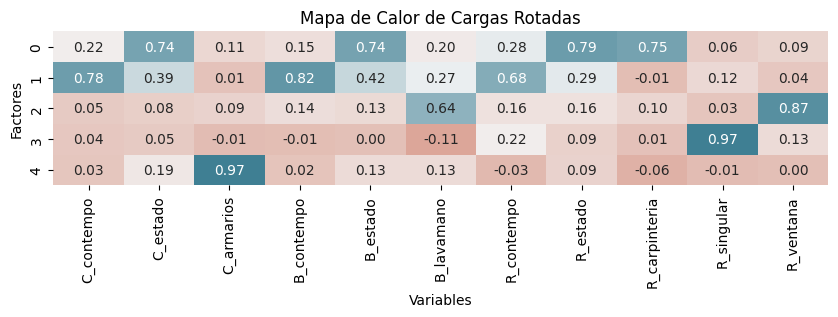

In [94]:
# Definir los colores para el mapa de calor
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Crear el mapa de calor
plt.figure(figsize=(10, 2)) #Altura y ancho, lo pueden variar
sns.heatmap(rotated_df2, cmap=cmap, annot=True, fmt=".2f", cbar=False, vmin=rotated_df.min().min(), vmax=rotated_df.max().max())
plt.title('Mapa de Calor de Cargas Rotadas')
plt.xlabel('Variables')
plt.ylabel('Factores')
plt.show()

## Rehacer

Ahora tengo que volver a hacer todo en `df` pero considerando sólo las filas que acabo de obtener de `df_og`.

In [95]:
# Filtrar df_og para mantener solo las filas cuyos IDs están en df
df=pd.merge(df, df_og[['ID']],on='ID',how='inner')
len(df)

1272

In [96]:
#Le indicamos en qué columnas se va a centrar
acp3 = df[calidad]

#Le pedimos un acp3 con rotación varimax y N factores
fa3 = FactorAnalyzer(rotation='varimax', n_factors=7, #esto lo indican ustedes, deben ir probando
                    method='principal')
fa3.fit(acp3)

# Obtener la varianza total explicada
total_variance = fa3.get_factor_variance()

# Crear un DataFrame para mostrar la tabla de la varianza total explicada
explained_variance_df = pd.DataFrame(total_variance, columns=['Factor1', 'Factor3','Factor3','Factor4',
                                                              'Factor5','Factor6','Factor7'], #Deben aumentar o disminuir según la
                                                                         #cantidad de factores que hayan indicado
                                     index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

#Esto es solo para que la tabla se vea mejor
explained_variance_df = explained_variance_df.transpose()

print("Tabla de Varianza Total Explicada:")
print(explained_variance_df)

Tabla de Varianza Total Explicada:
         SS Loadings  Proportion Var  Cumulative Var
Factor1     1.277506        0.116137        0.116137
Factor3     1.288751        0.117159        0.233296
Factor3     1.027797        0.093436        0.326732
Factor4     1.020182        0.092744        0.419476
Factor5     1.113414        0.101219        0.520696
Factor6     1.083844        0.098531        0.619227
Factor7     1.198142        0.108922        0.728149


In [97]:
rotated_loadings3 = fa3.loadings_

# Transponer la matriz de cargas rotadas para que las columnas coincidan con las variables
rotated_loadings_transposed3 = rotated_loadings3.T

rotated_df3 = pd.DataFrame(rotated_loadings_transposed3, columns=acp3.columns)

rotated_df3

,C_contempo,C_estado,C_armarios,B_contempo,B_estado,B_lavamano,R_contempo,R_estado,R_carpinteria,R_singular,R_ventana
0,0.786824,0.694075,0.059843,0.143673,0.074255,0.061699,0.018977,0.335671,-0.125843,0.113611,0.036755
1,-0.079526,0.225856,0.005496,0.068223,0.279162,-0.014159,0.013320,0.665689,0.823414,0.031589,0.162081
2,0.107148,-0.104456,0.058025,-0.107765,-0.476392,0.089724,0.221050,-0.028664,0.118587,-0.026601,0.831246
3,-0.088061,0.205182,0.974568,0.020272,0.103362,-0.013239,0.017653,0.027516,-0.011097,-0.015175,0.088620
4,0.022954,0.145120,-0.013473,-0.151845,0.219262,-0.007247,0.454982,0.002648,0.034267,0.898848,0.065896
5,-0.024499,0.131139,-0.000331,0.042329,0.392770,0.936469,0.059425,0.096064,-0.054507,0.008604,0.131174
6,0.253892,-0.075130,0.028848,0.829217,0.233930,0.036709,0.612627,0.049177,0.029859,-0.033971,0.061287


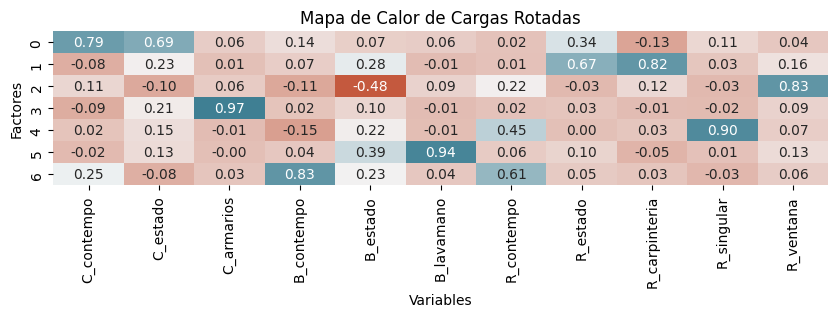

In [98]:
# Definir los colores para el mapa de calor
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Crear el mapa de calor
plt.figure(figsize=(10, 2)) #Altura y ancho, lo pueden variar
sns.heatmap(rotated_df3, cmap=cmap, annot=True, fmt=".2f", cbar=False, vmin=rotated_df.min().min(), vmax=rotated_df.max().max())
plt.title('Mapa de Calor de Cargas Rotadas')
plt.xlabel('Variables')
plt.ylabel('Factores')
plt.show()

No es posible obtener un factor que explique la *contemporaneidad* y el *estado* a la vez, como sí pasa con `df_og`. Por tanto procedo a hacer un modelo de regresión para ver la capacidad de explicación del precio con ambos dataframes.

# Regresión con datos predichos por los modelos

In [99]:
print(df.columns.tolist())

['ID', 'B_contempo', 'B_estado', 'B_lavamano', 'C_contempo', 'C_estado', 'C_armarios', 'R_contempo', 'R_estado', 'R_singular', 'R_ventana', 'R_carpinteria', 'precio_euros']


In [100]:
X = df[calidad]
y = df['precio_euros']

# Agregar una constante (Beta) a la matriz X para el término de intercepción del modelo
X = sm.add_constant(X) #'sm' es la librería 'statsmodels' que cargamos al inicio. Ya
                            #está configurada para que 'sepa' qué tiene que hacer

# Crear el modelo de regresión lineal
ols = sm.OLS(y, X) #noten que seguimos pidiendole que use 'sm'

# Ajustar el modelo a los datos
results = ols.fit()

# Imprimir el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           precio_euros   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     6.472
Date:                Wed, 19 Jun 2024   Prob (F-statistic):           1.52e-10
Time:                        08:25:49   Log-Likelihood:                -17843.
No. Observations:                1272   AIC:                         3.571e+04
Df Residuals:                    1260   BIC:                         3.577e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.467e+04   2.96e+04      2.864

# Regresión con datos del dataframe original

In [101]:
X = df_og[calidad]
y = df_og['precio_euros']

# Agregar una constante (Beta) a la matriz X para el término de intercepción del modelo
X = sm.add_constant(X) #'sm' es la librería 'statsmodels' que cargamos al inicio. Ya
                            #está configurada para que 'sepa' qué tiene que hacer

# Crear el modelo de regresión lineal
ols = sm.OLS(y, X) #noten que seguimos pidiendole que use 'sm'

# Ajustar el modelo a los datos
results = ols.fit()

# Imprimir el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           precio_euros   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     25.74
Date:                Wed, 19 Jun 2024   Prob (F-statistic):           1.31e-48
Time:                        08:25:49   Log-Likelihood:                -17749.
No. Observations:                1272   AIC:                         3.552e+04
Df Residuals:                    1260   BIC:                         3.558e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.177e+04   2.46e+04      1.701